<a href="https://colab.research.google.com/github/aditijantikar/BGGN239/blob/main/Tumor_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [81]:

try:
    # Spheroid (Experiment) Data
    df_spheroid_coords = pd.read_csv("macrophages-spheroid-spheroid.csv")
    df_tracks = pd.read_csv("macrophages-spheroid-tracks.csv")
    df_spots = pd.read_csv("macrophages-spheroid-spots.csv")

    # Control Data
    df_tracks_control = pd.read_csv("macrophages-tracks.csv")
    df_spots_control = pd.read_csv("macrophages-spots.csv")

    print("All 5 files loaded successfully.")

except FileNotFoundError as e:
    print(f"Error loading files: {e}")

print("\n Target (Y) Data: tracks.csv (Head) ")

print(df_tracks[['Track ID', 'Track Straightness', 'Track Shortest Distance to Spheroid']].head().to_markdown(index=False, numalign="left", stralign="left"))

print("\n Input (X) Data: spots.csv (Head) ")

print(df_spots[['Track ID', 'Time', 'Speed', 'Sphericity', 'Volume', 'Distance to Spheroid']].head().to_markdown(index=False, numalign="left", stralign="left"))

print("\n Spheroid Location Data: spheroid.csv (Head) ")

print(df_spheroid_coords.head().to_markdown(index=False, numalign="left", stralign="left"))

All 5 files loaded successfully.

 Target (Y) Data: tracks.csv (Head) 
| Track ID    | Track Straightness   | Track Shortest Distance to Spheroid   |
|:------------|:---------------------|:--------------------------------------|
| 1.00004e+09 | 0.078                | 267.99                                |
| 1.00004e+09 | 0.175                | 236.526                               |
| 1.00004e+09 | 0.036                | 253.986                               |
| 1.00004e+09 | 0.182                | 342.01                                |
| 1.00004e+09 | 0.041                | 286.882                               |

 Input (X) Data: spots.csv (Head) 
| Track ID    | Time   | Speed   | Sphericity   | Volume   | Distance to Spheroid   |
|:------------|:-------|:--------|:-------------|:---------|:-----------------------|
| 1.00004e+09 | 0      | 0.004   | 0.889        | 1010.11  | 292.506                |
| 1.00004e+09 | 0      | 0.004   | 0.884        | 3489.52  | 283.718              

In [23]:
# Remove blank rows at the end of the CSVs
df_tracks = df_tracks.dropna(subset=['Track ID'])
df_spots = df_spots.dropna(subset=['Track ID'])

In [24]:
# Convert both Track ID columns to integer for correct matching
df_tracks['Track ID'] = df_tracks['Track ID'].astype(np.int64)
df_spots['Track ID'] = df_spots['Track ID'].astype(np.int64)

In [25]:
# Create a a dict for our target variable
# This maps Track ID -> Shortest Distance
target_column = 'Track Shortest Distance to Spheroid'
target_lookup = df_tracks.set_index('Track ID')[target_column].to_dict()

In [26]:
input_features = [
    'Speed',
    'Sphericity',
    'Volume',
    'Distance to Spheroid'
]

In [27]:
scaler = StandardScaler()
df_spots[input_features] = scaler.fit_transform(df_spots[input_features])

In [82]:
X_sequences = []
y_targets = []
track_ids = []

In [29]:
grouped_spots = df_spots.groupby('Track ID')

for track_id, group in grouped_spots:

    if track_id in target_lookup:
        X_sequences.append(group[input_features].values)
        y_targets.append(target_lookup[track_id])
        track_ids.append(track_id)

print(f"Processed {len(X_sequences)} tracks that had both input data and a target value")

Processed 755 tracks that had both input data and a target value


In [30]:
max_len = max(len(seq) for seq in X_sequences)
print(f"Longest track has {max_len} time steps. Padding all sequences to this length.")

Longest track has 145 time steps. Padding all sequences to this length.


In [31]:
X_padded = pad_sequences(X_sequences, maxlen=max_len, dtype='float32', padding='post')

In [32]:
# Convert our target list (Y) to a numpy array
y_array = np.array(y_targets)

In [33]:
print("\n Data Prep Complete ")
print(f"Shape of Input (X) Array: {X_padded.shape}")
print(f"(Tracks, Max Time Steps, Features)")
print(f"\nShape of Target (Y) Array: {y_array.shape}")
print(f"(Tracks,)")


 Data Prep Complete 
Shape of Input (X) Array: (755, 145, 4)
(Tracks, Max Time Steps, Features)

Shape of Target (Y) Array: (755,)
(Tracks,)


In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X_padded,
    y_array,
    test_size=0.20,  # 20% for testing
    random_state=42  # used frequently in literature for reproducible results
)

print(" Data Split")
print(f"Training data (X_train) shape: {X_train.shape}")
print(f"Testing data (X_test) shape: {X_test.shape}")

 Data Split
Training data (X_train) shape: (604, 145, 4)
Testing data (X_test) shape: (151, 145, 4)


In [63]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, Bidirectional, BatchNormalization

configs = [
    (0.01, 32, 16, 0.4, 0.01, 32),
    (0.008, 32, 20, 0.35, 0.008, 32),
    (0.012, 40, 20, 0.35, 0.01, 32),
    (0.01, 32, 16, 0.35, 0.012, 24),
    (0.015, 32, 16, 0.45, 0.008, 32),
]

results = []

for i, (lr, lstm_units, dense_units, dropout, l2_reg, batch_size) in enumerate(configs):
    print(f"\n{'='*60}")
    print(f"Config {i+1}/{len(configs)}")
    print(f"LR={lr}, LSTM={lstm_units}, Dense={dense_units}, Dropout={dropout}, L2={l2_reg}, Batch={batch_size}")
    print(f"{'='*60}")

    #  model
    model = Sequential()
    model.add(Masking(mask_value=0.0, input_shape=(145, 4)))
    model.add(Bidirectional(LSTM(lstm_units, return_sequences=False, kernel_regularizer=l1_l2(l2=l2_reg))))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(Dense(dense_units, activation='relu', kernel_regularizer=l1_l2(l2=l2_reg)))
    model.add(Dropout(dropout*0.75))
    model.add(Dense(1, activation='linear'))

    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    # Train
    early_stop = EarlyStopping(monitor='val_mae', patience=20, restore_best_weights=True, verbose=0)
    reduce_lr_callback = ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=8, min_lr=1e-7, verbose=0)

    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=batch_size,
        validation_split=0.1,
        callbacks=[early_stop, reduce_lr_callback],
        verbose=0
    )

    # Evaluate
    test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
    print(f" Test MAE: {test_mae:.2f}")

    results.append({
        'config': i+1,
        'lr': lr,
        'lstm': lstm_units,
        'dense': dense_units,
        'dropout': dropout,
        'l2': l2_reg,
        'batch': batch_size,
        'mae': test_mae
    })

# Show results
print(f"\n{'='*80}")
print("Results summary")
print(f"{'='*80}")
for r in results:
    print(f"Config {r['config']}: MAE = {r['mae']:.2f}")

best = min(results, key=lambda x: x['mae'])
print(f"\n BEST: Config {best['config']} with MAE = {best['mae']:.2f}")


Config 1/5
LR=0.01, LSTM=32, Dense=16, Dropout=0.4, L2=0.01, Batch=32
 Test MAE: 15.83

Config 2/5
LR=0.008, LSTM=32, Dense=20, Dropout=0.35, L2=0.008, Batch=32
 Test MAE: 9.94

Config 3/5
LR=0.012, LSTM=40, Dense=20, Dropout=0.35, L2=0.01, Batch=32
 Test MAE: 10.54

Config 4/5
LR=0.01, LSTM=32, Dense=16, Dropout=0.35, L2=0.012, Batch=24
 Test MAE: 11.41

Config 5/5
LR=0.015, LSTM=32, Dense=16, Dropout=0.45, L2=0.008, Batch=32
 Test MAE: 12.55

Results summary
Config 1: MAE = 15.83
Config 2: MAE = 9.94
Config 3: MAE = 10.54
Config 4: MAE = 11.41
Config 5: MAE = 12.55

 BEST: Config 2 with MAE = 9.94


In [64]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2

# Rebuild Config 2 architecture
model = Sequential()
model.add(Masking(mask_value=0.0, input_shape=(145, 4)))
model.add(Bidirectional(LSTM(32, return_sequences=False, kernel_regularizer=l1_l2(l2=0.008))))
model.add(BatchNormalization())
model.add(Dropout(0.35))
model.add(Dense(20, activation='relu', kernel_regularizer=l1_l2(l2=0.008)))
model.add(Dropout(0.26))
model.add(Dense(1, activation='linear'))
optimizer = Adam(learning_rate=0.008)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_31 (Masking)            │ (None, 145, 4)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_22                │ (None, 64)             │         9,472 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 20)             │         1,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,049 (43.16 KB)

 Trainable params: 10,921 (42.66 KB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
checkpoint_callback = ModelCheckpoint(
    filepath="best_model_final.keras",
    monitor='val_mae',
    mode='min',
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(monitor='val_mae', patience=20, restore_best_weights=True, verbose=1)  # More patience
reduce_lr = ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=8, min_lr=1e-7, verbose=1)

print("model training starting")
history = model.fit(
    X_train,
    y_train,
    epochs=120,  # Even more epochs! Early stopping will catch it
    batch_size=32,
    validation_split=0.1,
    callbacks=[checkpoint_callback, early_stop, reduce_lr],
)

print("Model training complete")
print("\nEvaluating model on the test data")
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {test_loss:.2f}")
print(f"Test Mean Absolute Error (MAE): {test_mae:.2f}")


Model training starting
Epoch 1/100
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 70033.4531 - mae: 210.2011
Epoch 1: val_mae improved from inf to 225.19167, saving model to best_model_final.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 70598.4609 - mae: 212.0433 - val_loss: 76809.3672 - val_mae: 225.1917 - learning_rate: 0.0080
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 58481.7109 - mae: 199.4992
Epoch 2: val_mae improved from 225.19167 to 191.76538, saving model to best_model_final.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 58024.3203 - mae: 198.7417 - val_loss: 53336.2852 - val_mae: 191.7654 - learning_rate: 0.0080
Epoch 3/100
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 27165.5332 - mae: 137.9987
Epoch 3: val_mae improved from 191.76538 to 141.98715, saving model to best_model_final.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 26439.7227 - mae: 135.6347 - val_loss: 27949.9883 - val_mae: 141.9872 - learning_rate: 0.0080
Epoch 4/100


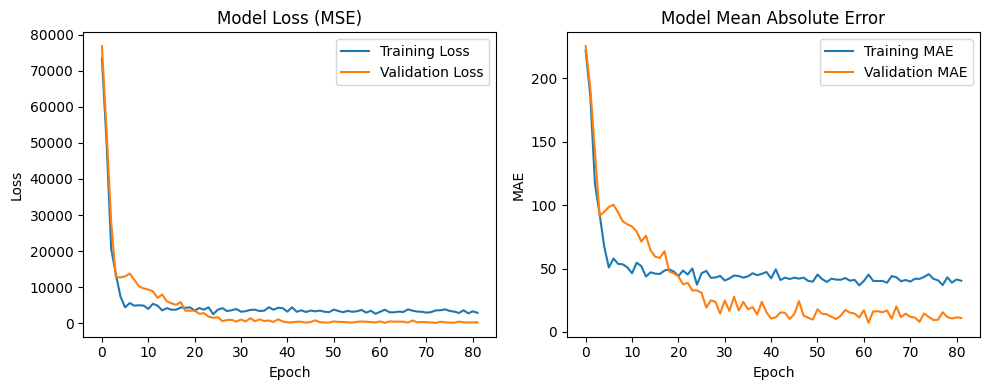

In [65]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint_callback = ModelCheckpoint(
    filepath="best_model_final.keras",
    monitor='val_mae',
    mode='min',
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(monitor='val_mae', patience=20, restore_best_weights=True, verbose=1)
reduce_lr_callback = ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=8, min_lr=1e-7, verbose=1)

print("\nModel training starting")

history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=[checkpoint_callback, early_stop, reduce_lr_callback],
    verbose=1
)

print("Model training complete")

print("\nEvaluating model on the test data")
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)

print(f"Test Loss (MSE): {test_loss:.2f}")
print(f"Test Mean Absolute Error (MAE): {test_mae:.2f}")

# Plot
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [66]:
print(f"y_train min: {y_train.min()}")
print(f"y_train max: {y_train.max()}")
print(f"y_train mean: {y_train.mean():.2f}")
print(f"y_train std: {y_train.std():.2f}")

y_train min: -57.2159996
y_train max: 661.2020264
y_train mean: 224.69
y_train std: 171.29


In [67]:
print(y_train[:5])

[ 34.09999847 294.427002   552.473999   378.1549988  314.0100098 ]


In [68]:
print("First track, first 5 timesteps:")
print(X_train[0, :5, :])
print("\nFeature names:")

First track, first 5 timesteps:
[[-0.7076889   0.41002977  1.7301352  -1.2119638 ]
 [-0.4908681   0.17565838  1.8342578  -1.2188041 ]
 [-0.27404726  0.2225321   1.9176923  -1.2119881 ]
 [-0.7076889  -0.4649575   1.9385645  -1.218871  ]
 [-0.7076889  -0.44933295  1.9000751  -1.220289  ]]

Feature names:


In [69]:
!pip install shap --break-system-packages

import shap
import numpy as np
import matplotlib.pyplot as plt

In [80]:
"""
FEATURE COMBINATION ANALYSIS FOR TUMOR INFILTRATION
Find which COMBINATIONS of features cause macrophages to infiltrate tumors
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
import pandas as pd

results_data = {
    'Feature 1': ['Speed', 'Sphericity', 'Volume', 'Speed', 'Speed', 'Sphericity'],
    'Feature 2': ['Distance to Spheroid', 'Distance to Spheroid', 'Distance to Spheroid',
                  'Sphericity', 'Volume', 'Volume'],
    'Importance': [179.31, 166.17, 165.90, 51.04, 49.52, 48.31],
    'MAE': [189.38, 176.24, 175.97, 61.10, 59.59, 58.37]
}

print("ANALYZING FEATURE COMBINATIONS FOR TUMOR INFILTRATION")
print("\n Which pairs of features matter most together?\n")

baseline_predictions = model.predict(X_test, verbose=0)
baseline_mae = mean_absolute_error(y_test, baseline_predictions)

interaction_scores = []

# Test all pairs
from itertools import combinations

for feat1, feat2 in combinations(range(4), 2):
    name1, name2 = feature_names[feat1], feature_names[feat2]

    # Shuffle both features together
    X_test_shuffled = X_test.copy()
    np.random.shuffle(X_test_shuffled[:, :, feat1])
    np.random.shuffle(X_test_shuffled[:, :, feat2])

    # Predict
    shuffled_predictions = model.predict(X_test_shuffled, verbose=0)
    shuffled_mae = mean_absolute_error(y_test, shuffled_predictions)

    importance = shuffled_mae - baseline_mae
    interaction_scores.append({
        'Feature 1': name1,
        'Feature 2': name2,
        'Importance': importance,
        'MAE': shuffled_mae
    })

    print(f"{name1:20s} +  {name2:20s} → Importance: {importance:6.2f}")

# Sort by importance
interaction_df = pd.DataFrame(interaction_scores).sort_values('Importance', ascending=False)

print("\n Best 2 feature combinations:")
print(interaction_df.to_string(index=False))

ANALYZING FEATURE COMBINATIONS FOR TUMOR INFILTRATION

 Which pairs of features matter most together?

Speed                +  Sphericity           → Importance:  52.77
Speed                +  Volume               → Importance:  49.60
Speed                +  Distance to Spheroid → Importance: 164.96
Sphericity           +  Volume               → Importance:  53.57
Sphericity           +  Distance to Spheroid → Importance: 171.63
Volume               +  Distance to Spheroid → Importance: 164.29

 Best 2 feature combinations:
 Feature 1            Feature 2  Importance        MAE
Sphericity Distance to Spheroid  171.632526 181.699450
     Speed Distance to Spheroid  164.955031 175.021956
    Volume Distance to Spheroid  164.293816 174.360741
Sphericity               Volume   53.574306  63.641231
     Speed           Sphericity   52.768635  62.835559
     Speed               Volume   49.596169  59.663093


In [72]:
#  Correlation Between Features and Target

print(" How do feature values correlate with infiltration?")

# Flatten time dimension - take mean across timesteps for each track
X_test_avg = np.mean(X_test, axis=1)  # Shape: (151, 4)

# Create correlation analysis
print("\nAverage feature values for:")
print(" Tracks that GET CLOSE to tumor (y < 100)")
print(" Tracks that STAY FAR from tumor (y > 400)")

close_tracks = y_test < 100
far_tracks = y_test > 400

print(f"\nClose tracks (n={close_tracks.sum()}):")
for i, name in enumerate(feature_names):
    avg_close = X_test_avg[close_tracks, i].mean()
    print(f"  {name:25s}: {avg_close:8.4f}")

print(f"\nFar tracks (n={far_tracks.sum()}):")
for i, name in enumerate(feature_names):
    avg_far = X_test_avg[far_tracks, i].mean()
    print(f"  {name:25s}: {avg_far:8.4f}")

print("\nDifference (Close - Far):")
for i, name in enumerate(feature_names):
    avg_close = X_test_avg[close_tracks, i].mean()
    avg_far = X_test_avg[far_tracks, i].mean()
    diff = avg_close - avg_far
    print(f"  {name:25s}: {diff:8.4f}")


 How do feature values correlate with infiltration?

Average feature values for:
 Tracks that GET CLOSE to tumor (y < 100)
 Tracks that STAY FAR from tumor (y > 400)

Close tracks (n=45):
  Speed                    :   0.1840
  Sphericity               :  -0.0811
  Volume                   :  -0.0563
  Distance to Spheroid     :  -0.4774

Far tracks (n=28):
  Speed                    :  -0.1507
  Sphericity               :  -0.1162
  Volume                   :   0.0060
  Distance to Spheroid     :   0.8505

Difference (Close - Far):
  Speed                    :   0.3347
  Sphericity               :   0.0351
  Volume                   :  -0.0623
  Distance to Spheroid     :  -1.3280


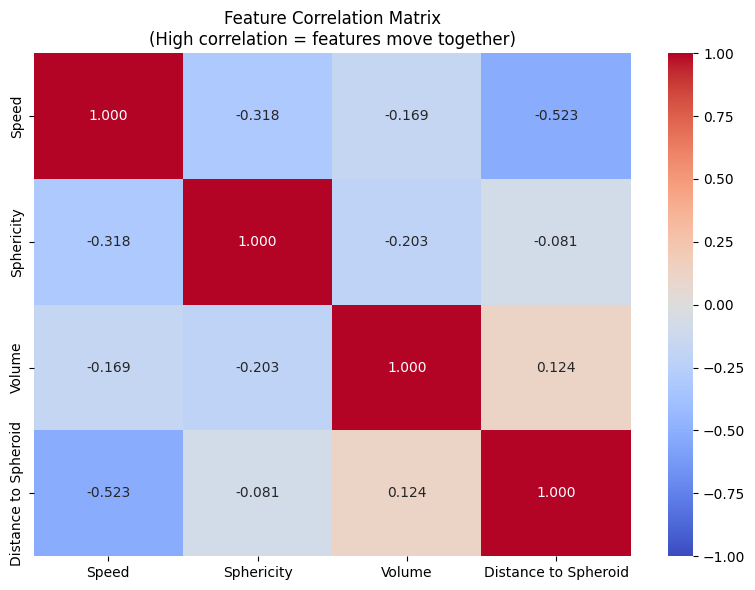

In [74]:
#  Correlation Matrix
# Calculate correlations between features
correlation_matrix = np.corrcoef(X_test_avg.T)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f',
            xticklabels=feature_names, yticklabels=feature_names,
            cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix\n(High correlation = features move together)')
plt.tight_layout()
plt.show()


In [75]:

# Identify Infiltration Patterns

print("What patterns predict successful infiltration?")


# Define successful infiltration
infiltrating = y_test < 150  # Gets close to tumor
non_infiltrating = y_test > 300  # Stays far

print(f"\nInfiltrating tracks (y < 150): {infiltrating.sum()}")
print(f"Non-infiltrating tracks (y > 300): {non_infiltrating.sum()}")

# Compare feature patterns
print("\n INFILTRATING vs NON-INFILTRATING:")
print("-" * 60)
print(f"{'Feature':<25s} | {'Infiltrating':<12s} | {'Non-infiltrating':<12s} | {'Difference'}")
print("-" * 60)

for i, name in enumerate(feature_names):
    infiltrating_avg = X_test_avg[infiltrating, i].mean()
    non_infiltrating_avg = X_test_avg[non_infiltrating, i].mean()
    diff = infiltrating_avg - non_infiltrating_avg

    print(f"{name:<25s} | {infiltrating_avg:>12.4f} | {non_infiltrating_avg:>12.4f} | {diff:>10.4f}")



What patterns predict successful infiltration?

Infiltrating tracks (y < 150): 52
Non-infiltrating tracks (y > 300): 57

 INFILTRATING vs NON-INFILTRATING:
------------------------------------------------------------
Feature                   | Infiltrating | Non-infiltrating | Difference
------------------------------------------------------------
Speed                     |       0.1704 |      -0.1408 |     0.3112
Sphericity                |      -0.0561 |       0.0007 |    -0.0567
Volume                    |      -0.0656 |      -0.0239 |    -0.0417
Distance to Spheroid      |      -0.4523 |       0.5846 |    -1.0369


In [76]:
# METHOD 5: Statistical Analysis of Combinations

print(" Multi-feature patterns")
print("\nTesting specific feature combinations:")

# Combo 1: High Speed + Low Distance
high_speed = X_test_avg[:, 0] > np.median(X_test_avg[:, 0])
low_distance = X_test_avg[:, 3] < np.median(X_test_avg[:, 3])
combo1 = high_speed & low_distance
print(f"\n1. High Speed + Low Distance:")
print(f"   Tracks with this combo: {combo1.sum()}")
print(f"   Average final distance: {y_test[combo1].mean():.2f}")
print(f"   Overall average: {y_test.mean():.2f}")

# Combo 2: High Sphericity + High Volume
high_sphericity = X_test_avg[:, 1] > np.median(X_test_avg[:, 1])
high_volume = X_test_avg[:, 2] > np.median(X_test_avg[:, 2])
combo2 = high_sphericity & high_volume
print(f"\n2. High Sphericity + High Volume:")
print(f"   Tracks with this combo: {combo2.sum()}")
print(f"   Average final distance: {y_test[combo2].mean():.2f}")
print(f"   Overall average: {y_test.mean():.2f}")

# Combo 3: All favorable features
high_speed_med = X_test_avg[:, 0] > np.median(X_test_avg[:, 0])
high_spher_med = X_test_avg[:, 1] > np.median(X_test_avg[:, 1])
high_vol_med = X_test_avg[:, 2] > np.median(X_test_avg[:, 2])
low_dist_med = X_test_avg[:, 3] < np.median(X_test_avg[:, 3])

combo3 = high_speed_med & high_spher_med & high_vol_med & low_dist_med
print(f"\n3. ALL FAVORABLE (High Speed + Sphericity + Volume + Low Distance):")
print(f"   Tracks with this combo: {combo3.sum()}")
if combo3.sum() > 0:
    print(f"   Average final distance: {y_test[combo3].mean():.2f}")
    print(f"   Overall average: {y_test.mean():.2f}")


 Multi-feature patterns

Testing specific feature combinations:

1. High Speed + Low Distance:
   Tracks with this combo: 56
   Average final distance: 58.64
   Overall average: 231.88

2. High Sphericity + High Volume:
   Tracks with this combo: 33
   Average final distance: 244.59
   Overall average: 231.88

3. ALL FAVORABLE (High Speed + Sphericity + Volume + Low Distance):
   Tracks with this combo: 8
   Average final distance: 103.33
   Overall average: 231.88


In [77]:
# SUMMARY
print(" SUMMARY: KEY COMBINATIONS FOR TUMOR INFILTRATION")

print("\n1. Most important 2-feature pairs:")
print(interaction_df.head(3).to_string(index=False))

print("\n2. Features that differ most between infiltrating vs non-infiltrating:")
differences = []
for i, name in enumerate(feature_names):
    infiltrating_avg = X_test_avg[infiltrating, i].mean()
    non_infiltrating_avg = X_test_avg[non_infiltrating, i].mean()
    diff = abs(infiltrating_avg - non_infiltrating_avg)
    differences.append((name, diff))

differences.sort(key=lambda x: x[1], reverse=True)
for name, diff in differences:
    print(f"   {name}: {diff:.4f}")

 SUMMARY: KEY COMBINATIONS FOR TUMOR INFILTRATION

1. Most important 2-feature pairs:
 Feature 1            Feature 2  Importance        MAE
    Volume Distance to Spheroid  163.606907 173.673832
     Speed Distance to Spheroid  161.391358 171.458282
Sphericity Distance to Spheroid  151.917311 161.984236

2. Features that differ most between infiltrating vs non-infiltrating:
   Distance to Spheroid: 1.0369
   Speed: 0.3112
   Sphericity: 0.0567
   Volume: 0.0417
